<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_FFN_FFNonMNIST_Binarized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

In [3]:
# shape of the data matrix
data.shape

(20000, 785)

In [4]:
# extract labels (numbers IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


In [11]:
a = np.array([[1,2,3], [2,3,5]])
b = (a < 5)
b.astype(int)

array([[1, 1, 1],
       [1, 1, 0]])

In [26]:
binarized_data = (data > 0).astype(float)
binarized_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

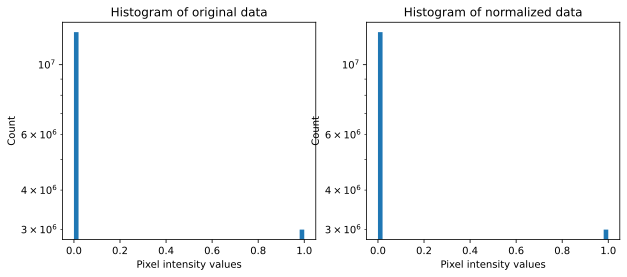

In [27]:
# normalize the data to a range of [0 1]
dataNorm = binarized_data / np.max(binarized_data)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(binarized_data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title("Histogram of original data")
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

## Create train/test groups using dataloader

In [28]:
# step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

# step 2: use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)

# step 3: convert into pyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [29]:
# check all variables in workspace
%whos

Variable                 Type             Data/Info
---------------------------------------------------
DataLoader               type             <class 'torch.utils.data.dataloader.DataLoader'>
F                        module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset            type             <class 'torch.utils.data.dataset.TensorDataset'>
X                        Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
a                        ndarray          2x3: 6 elems, type `int64`, 48 bytes
ax                       ndarray          2: 2 elems, type `object`, 16 bytes
b                        ndarray          2x3: 6 elems, type `bool`, 6 bytes
batchsize                int              32
binarized_data           ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
createTheMNISTNet        function         <function createTheMNISTNet at 0x7ff0a4096950>
data                     ndarra

## Create the DL model

In [30]:
# create a class for the model

def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            ## input layer
            self.input = nn.Linear(784, 64)

            ## hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            ## output layer
            self.output = nn.Linear(32, 10)
        
        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return torch.log_softmax(self.output(x), axis=1)

        
    net = mnistNet()

    # loss function 
    lossfun = nn.NLLLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

In [31]:
# test the model with one batch
net, lossfun, optimizer = createTheMNISTNet()

X, y = iter(train_loader).next()
yHat = net(X)
# value s are log-probability of each number (0-9)
print(yHat.shape)
# now let's compute the loss
loss = lossfun(yHat, y)
print(' ')
print('Loss: ')
print(loss)

torch.Size([32, 10])
 
Loss: 
tensor(2.3076, grad_fn=<NllLossBackward0>)


In [32]:
def function2trainTheModel():

    # number of epochs
    numepochs = 60

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y 
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric) 
            batchAcc.append(accuracyPct) 

        # end of batch loop

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))
        yHat = net(X)

        # compare the following really lon gline of code the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

    # end epochs
    
    # function output
    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [33]:
trainAcc, testAcc, losses, net = function2trainTheModel()

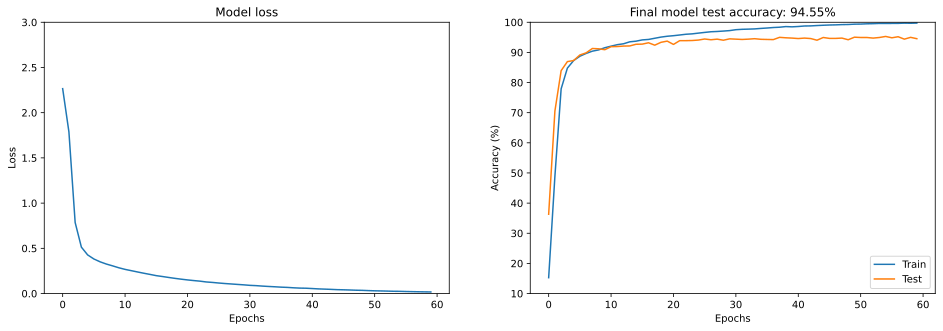

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].set_ylim([10, 100])
ax[1].legend()

plt.show()

## Inspect the results in more detail

In [35]:
# run the model through for the test data
X, y = next(iter(test_loader))
predictions = net(X).detach()

In [36]:
torch.exp(predictions)

tensor([[9.4585e-10, 9.4019e-05, 2.0947e-09,  ..., 1.0507e-09, 7.5899e-06,
         5.0980e-09],
        [7.1619e-04, 9.4677e-12, 1.9410e-07,  ..., 4.0743e-15, 8.2761e-04,
         2.2519e-13],
        [3.4389e-05, 5.4858e-13, 7.7997e-08,  ..., 2.1211e-07, 5.5076e-05,
         4.4354e-01],
        ...,
        [8.4953e-14, 9.4082e-04, 9.9905e-01,  ..., 1.3540e-09, 5.4741e-10,
         3.7018e-23],
        [3.3226e-10, 3.0811e-02, 2.5936e-07,  ..., 1.1329e-05, 7.9018e-06,
         2.6712e-07],
        [1.2144e-08, 2.0129e-10, 1.0000e+00,  ..., 6.4904e-09, 1.0265e-10,
         2.5124e-15]])

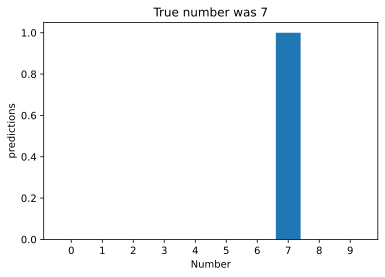

In [37]:
# Evidence for all numbers from one sample
sample2show = 323

plt.bar(range(10), torch.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('predictions')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  13   36   40   53   57   59   67   76   78   85   86   88   96  115
  130  144  145  205  235  252  297  299  310  311  315  354  368  375
  378  410  417  424  443  448  467  503  508  525  607  622  645  665
  683  689  697  704  705  719  721  765  778  796  825  850  854  903
  906  914  928  955  974 1008 1048 1092 1098 1117 1158 1179 1187 1192
 1270 1285 1306 1311 1324 1325 1352 1371 1390 1436 1457 1485 1489 1528
 1535 1539 1556 1567 1576 1604 1607 1608 1620 1622 1625 1657 1659 1691
 1705 1720 1728 1754 1777 1799 1822 1825 1844 1875 1977]


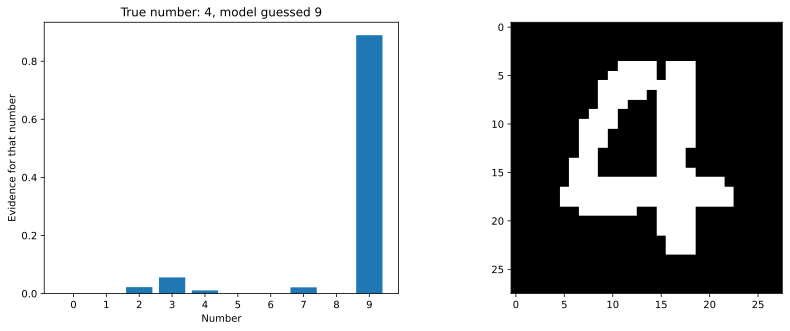

In [38]:
# find the errors
errors = np.where(torch.max(predictions, axis=1)[1] != y)[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 4

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'%(y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item()))
ax[1].imshow(np.reshape(X[errors[sample2show], :], (28, 28)), cmap='gray')

plt.show()